# Resistance plant gene prediction - Modeling
---

## Libraries

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Data preparation and scaling
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import f1_score

# Tokenization
from tensorflow.keras.preprocessing.text import Tokenizer

# Modeling library
import tensorflow as tf
from tensorflow.keras.models import Model

# Modeling Layers
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.layers import Conv1D, Reshape, MaxPooling1D, Flatten


# Speed up the model's training
from tensorflow.keras import mixed_precision


# Helper functions and Layers
import helper_functions as hf
from Positional_encoding import PositionalEncoding

2024-05-30 22:13:08.108322: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 22:13:08.132574: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 22:13:08.132585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 22:13:08.133179: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-30 22:13:08.137404: I tensorflow/core/platform/cpu_feature_guar

## Data loading

In [2]:
proteins = pd.read_csv('Data/train.csv')

In [3]:
proteins.head()

,ID,Sequence,Label
0,0,MDSRMDQYEVMEQIGRGAFGAAILVNHKTEKKKYVLKKIRLARQTE...,0
1,4,MAPKAEKKPAEKKPAEEKAGEKAPAAGKKPKAEKRLPASKGEKGGE...,0
2,5,MLELHFEFIDLNQPKMYKFVVCLLTLSFLLLSGLSNTALARVHHES...,0
3,6,MAEPELVNGGVKENKLWKGVFAVSGIMSTLVIYGVLQEKIMRVPYG...,0
4,7,MTSCGCLVLEKVEDHGGEAAGRGRGRLAQGGGGGGGGCGSCAGEWR...,0


In [4]:
proteins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14161 entries, 0 to 14160
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        14161 non-null  int64 
 1   Sequence  14161 non-null  object
 2   Label     14161 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 332.0+ KB


In [5]:
proteins[proteins.duplicated()].shape

(0, 3)

In [6]:
proteins = proteins[proteins['Sequence'].str.len() < 1000]

In [7]:
labels = pd.DataFrame(proteins['Label'])
labels.head()

,Label
0,0
1,0
2,0
3,0
4,0


In [8]:
sequences = proteins['Sequence']
sequences.head()

0    MDSRMDQYEVMEQIGRGAFGAAILVNHKTEKKKYVLKKIRLARQTE...
1    MAPKAEKKPAEKKPAEEKAGEKAPAAGKKPKAEKRLPASKGEKGGE...
2    MLELHFEFIDLNQPKMYKFVVCLLTLSFLLLSGLSNTALARVHHES...
3    MAEPELVNGGVKENKLWKGVFAVSGIMSTLVIYGVLQEKIMRVPYG...
4    MTSCGCLVLEKVEDHGGEAAGRGRGRLAQGGGGGGGGCGSCAGEWR...
Name: Sequence, dtype: object

## Data Preparation

### Tokenization

#### Char level

* Tokenize the sequences on char level

In [9]:
# Tokenize on char level
tokenizer1 = Tokenizer(char_level=True)
tokenizer1.fit_on_texts(sequences)
sequences_1p = tokenizer1.texts_to_sequences(sequences)

# Padd the sequences to match all the length of the biggest
sequences_1p = pad_sequences(sequences_1p, padding='post')

In [10]:
sequences_1p

array([[17,  9,  2, ...,  0,  0,  0],
       [17,  3, 12, ...,  0,  0,  0],
       [17,  1,  6, ...,  0,  0,  0],
       ...,
       [17, 16, 14, ...,  0,  0,  0],
       [17,  3,  3, ...,  0,  0,  0],
       [17,  4, 10, ...,  0,  0,  0]], dtype=int32)

* Max sequence length

In [11]:
len(sequences_1p[0])

997

#### 2 Amino Pairs

* Split the sequences per 2 aminos

In [12]:
dipeptide_sequences = hf.split_sequences(sequences, step=2)
pd.DataFrame(dipeptide_sequences[500])

,0
0,MD
1,AN
2,FE
3,MP
4,PV
...,...
271,NM
272,FA
273,KL
274,SK


In [13]:
sequences[500]

'MASAEGGGDKYRSFLHGDGEKKTVWRHGAPPNYDLVNKLFEEERTKEWAEGSVEEKVQRLLKTWEMEMVHKVRPEDQKSVNLKNYSASTNGLKPLTREEVMAMGGYNAFLATTLPPEHRIYDPEAESVESATSTFLTAFPRGFAIEVLDVYSSPSAPRIAFKFRHWGYMEGPFKGHPPHGGRVEFFGVCVFHVDEDTKVEKAEFFYERGNFLASFLTAPAASASASGCPVMRGAD'

In [14]:
tokenizer2 = Tokenizer(char_level=False)
tokenizer2.fit_on_texts(dipeptide_sequences)
sequences_2p = tokenizer2.texts_to_sequences(dipeptide_sequences)
sequences_2p = pad_sequences(sequences_2p, padding='post')

In [15]:
sequences_2p

array([[256,  57, 256, ...,   0,   0,   0],
       [126, 149,  56, ...,   0,   0,   0],
       [195,  20, 322, ...,   0,   0,   0],
       ...,
       [367, 179, 254, ...,   0,   0,   0],
       [126,  89, 253, ...,   0,   0,   0],
       [227, 321,  75, ...,   0,   0,   0]], dtype=int32)

* Max length

In [16]:
len(sequences_2p[0])

499

#### 3 Amino Pairs

* Split the sequences per 3 aminos

In [17]:
tripeptide_sequences = hf.split_sequences(sequences, step=3)
pd.DataFrame(tripeptide_sequences[500])

,0
0,MDA
1,NFE
2,MPP
3,VGG
4,MND
...,...
179,AKF
180,YGN
181,MFA
182,KLS


In [18]:
sequences[500]

'MASAEGGGDKYRSFLHGDGEKKTVWRHGAPPNYDLVNKLFEEERTKEWAEGSVEEKVQRLLKTWEMEMVHKVRPEDQKSVNLKNYSASTNGLKPLTREEVMAMGGYNAFLATTLPPEHRIYDPEAESVESATSTFLTAFPRGFAIEVLDVYSSPSAPRIAFKFRHWGYMEGPFKGHPPHGGRVEFFGVCVFHVDEDTKVEKAEFFYERGNFLASFLTAPAASASASGCPVMRGAD'

In [19]:
tokenizer3 = Tokenizer(char_level=False)
tokenizer3.fit_on_texts(tripeptide_sequences)
sequences_3p = tokenizer3.texts_to_sequences(tripeptide_sequences)
sequences_3p = pad_sequences(sequences_3p, padding='post')

In [20]:
sequences_3p

array([[2109, 5723, 5998, ...,    0,    0,    0],
       [1845,  749, 1140, ...,    0,    0,    0],
       [2045, 3704, 2843, ...,    0,    0,    0],
       ...,
       [6676, 5322, 2979, ...,    0,    0,    0],
       [ 174, 4038, 2436, ...,    0,    0,    0],
       [3427, 4256, 1161, ...,    0,    0,    0]], dtype=int32)

* Max length

In [21]:
len(sequences_3p[0])

333

### Train Test Split

#### Char level split

In [22]:
sequences_1p_train, sequences_1p_test, labels_1p_train, labels_1p_test = train_test_split(sequences_1p, labels, test_size=0.2, random_state=33)

In [23]:
print('Training shapes: ', sequences_1p_train.shape, labels_1p_train.shape)
print('Test shapes: ', sequences_1p_test.shape, labels_1p_test.shape)

Training shapes:  (10805, 997) (10805, 1)
Test shapes:  (2702, 997) (2702, 1)


In [24]:
scaler = StandardScaler()
sequences_1p_train_scaled = scaler.fit_transform(sequences_1p_train)
sequences_1p_test_scaled = scaler.fit_transform(sequences_1p_test)

In [25]:
# pd.DataFrame(sequences_1p_train).to_csv('Data/Prepared_Data/1_Amino_Pair/train.csv')
# pd.DataFrame(sequences_1p_test).to_csv('Data/Prepared_Data/1_Amino_Pair/test.csv')

# pd.DataFrame(labels_1p_train).to_csv('Data/Prepared_Data/1_Amino_Pair/labels_train.csv')
# pd.DataFrame(labels_1p_test).to_csv('Data/Prepared_Data/1_Amino_Pair/labels_test.csv')

In [26]:
# pd.DataFrame(sequences_1p_train_scaled).to_csv('Data/Prepared_Data/1_Amino_Pair/train_scaled.csv')
# pd.DataFrame(sequences_1p_test_scaled).to_csv('Data/Prepared_Data/1_Amino_Pair/test_scaled.csv')

#### 2 Aminos split

In [27]:
sequences_2p_train, sequences_2p_test, labels_2p_train, labels_2p_test = train_test_split(sequences_2p, labels, test_size=0.2, random_state=33)

In [28]:
print('Training shapes: ', sequences_2p_train.shape, labels_2p_train.shape)
print('Test shapes: ', sequences_2p_test.shape, labels_2p_test.shape)

Training shapes:  (10805, 499) (10805, 1)
Test shapes:  (2702, 499) (2702, 1)


In [29]:
sequences_2p_train_scaled = scaler.fit_transform(sequences_2p_train)
sequences_2p_test_scaled = scaler.fit_transform(sequences_2p_test)

In [30]:
# pd.DataFrame(sequences_2p_train).to_csv('Data/Prepared_Data/2_Amino_Pair/train.csv')
# pd.DataFrame(sequences_2p_test).to_csv('Data/Prepared_Data/2_Amino_Pair/test.csv')

# pd.DataFrame(labels_2p_train).to_csv('Data/Prepared_Data/2_Amino_Pair/labels_train.csv')
# pd.DataFrame(labels_2p_test).to_csv('Data/Prepared_Data/2_Amino_Pair/labels_test.csv')

In [31]:
# pd.DataFrame(sequences_2p_train_scaled).to_csv('Data/Prepared_Data/2_Amino_Pair/train_scaled.csv')
# pd.DataFrame(sequences_2p_test_scaled).to_csv('Data/Prepared_Data/2_Amino_Pair/test_scaled.csv')

#### 3 Aminos split

In [32]:
sequences_3p_train, sequences_3p_test, labels_3p_train, labels_3p_test = train_test_split(sequences_3p, labels, test_size=0.2, random_state=33)

In [33]:
print('Training shapes: ', sequences_3p_train.shape, labels_3p_train.shape)
print('Test shapes: ', sequences_3p_test.shape, labels_3p_test.shape)

Training shapes:  (10805, 333) (10805, 1)
Test shapes:  (2702, 333) (2702, 1)


In [34]:
sequences_3p_train_scaled = scaler.fit_transform(sequences_3p_train)
sequences_3p_test_scaled = scaler.fit_transform(sequences_3p_test)

In [35]:
# pd.DataFrame(sequences_3p_train).to_csv('Data/Prepared_Data/3_Amino_Pair/train.csv')
# pd.DataFrame(sequences_3p_test).to_csv('Data/Prepared_Data/3_Amino_Pair/test.csv')

# pd.DataFrame(labels_3p_train).to_csv('Data/Prepared_Data/3_Amino_Pair/labels_train.csv')
# pd.DataFrame(labels_3p_test).to_csv('Data/Prepared_Data/3_Amino_Pair/labels_test.csv')

In [36]:
# pd.DataFrame(sequences_3p_train_scaled).to_csv('Data/Prepared_Data/3_Amino_Pair/train_scaled.csv')
# pd.DataFrame(sequences_3p_test_scaled).to_csv('Data/Prepared_Data/3_Amino_Pair/test_scaled.csv')

## Mixed precision

* Set up mix precision before modeling to speed up the training

In [37]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-ab9b9fbd-4e42-e44a-c243-d1a9ea6686fe)


In [38]:
tf.config.list_physical_devices()

2024-05-30 22:13:12.799985: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 22:13:12.815356: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-30 22:13:12.815397: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [39]:
mixed_precision.set_global_policy(policy='mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


2024-05-30 22:13:12.830022: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [40]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Modeling (Amino Frequence)

In [42]:
sequences = pd.DataFrame(sequences)
sequences

,Sequence
0,MDSRMDQYEVMEQIGRGAFGAAILVNHKTEKKKYVLKKIRLARQTE...
1,MAPKAEKKPAEKKPAEEKAGEKAPAAGKKPKAEKRLPASKGEKGGE...
2,MLELHFEFIDLNQPKMYKFVVCLLTLSFLLLSGLSNTALARVHHES...
3,MAEPELVNGGVKENKLWKGVFAVSGIMSTLVIYGVLQEKIMRVPYG...
4,MTSCGCLVLEKVEDHGGEAAGRGRGRLAQGGGGGGGGCGSCAGEWR...
...,...
14156,MGLKEEFEEHAEKVNTLTELPSNEDLLILYGLYKQAKFGPVDTSRP...
14157,MMMMGEGVSSVPPWSHLPVSGVDVLGGGGGGGDEMTPYVIAALRDY...
14158,MYNNNQYSFSGDEDSVVLSLGPPGQQYPSHNKPTSTKPSSDHEFNH...
14159,MAARCSIAFMIMASCLSVVVSGGLPGDLFALSVASKLRVDRNSTAR...


In [43]:
labels

,Label
0,0
1,0
2,0
3,0
4,0
...,...
14156,0
14157,0
14158,0
14159,0


In [87]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

In [88]:
print(X_train.shape)
print(y_train.shape)

(10805, 1)
(10805, 1)


In [89]:
print(X_test.shape)
print(y_test.shape)

(2702, 1)
(2702, 1)


In [90]:
y_train_pos = y_train[y_train.Label == 1]
X_train_pos = X_train[X_train.index.isin(y_train_pos.index)]

In [91]:
y_train_neg = y_train[y_train.Label == 0]
X_train_neg = X_train[X_train.index.isin(y_train_neg.index)]
X_train_neg = X_train_neg.sample(X_train_pos.shape[0])

In [92]:
print(X_train_pos.shape)
print(X_train_neg.shape)

(958, 1)
(958, 1)


In [93]:
X_train = pd.concat([X_train_pos, X_train_neg]).sort_index(ascending=True)
X_train

,Sequence
7,MENLSNPDENDDHQSPRSIDQNDQSAVETPVYSTMSIDSFVYPRTC...
12,MLPSHLNGHSPLARRCPRLSAASPPATGDSDAAAAAADAPLAEHDR...
18,MVLAELGGSISRALQQMSNATIIDEKVLNECLNEITRALLQADVQF...
22,MKKLRYVHLNLLLLLLPLINLQFPTLSLAQDYDEPKKDDTPPPGLA...
28,MDRPPSLPHYQNPNPNLFYHYPPPNSNPNFFFRPPPPPLQNPNNYS...
...,...
14144,MASLSFASSHASLFCCQQSSSAIILRPAGALLRLSRRQPSSHTIST...
14145,MAHAAAATGALAPLHPLLRCTSRHLCASASPRAGLCLHHHRRRRRS...
14150,MNTIVLFLTLLILVSSCTSIVMKSSNSKERTYPVTPALNPLTGQHS...
14152,MASNKISFSFVLCLYMCSLLDAKSMNPTGRRCPDPNGVEKKSMCYS...


In [94]:
y_train = y_train[y_train.index.isin(X_train.index)].sort_index(ascending=True)
y_train

,Label
7,0
12,0
18,0
22,0
28,0
...,...
14144,1
14145,0
14150,1
14152,1


In [95]:
AMINO_ACIDS = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L",
               "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]

def get_amino_acid_frequency(seq):
    amino_acid_frequency = [seq.count(amino_acid) for amino_acid in AMINO_ACIDS]
    return np.array(amino_acid_frequency)

In [96]:
X_train_features = np.array([get_amino_acid_frequency(seq[0]) for seq in X_train.values])
X_test_features = np.array([get_amino_acid_frequency(seq[0]) for seq in X_test.values])

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_features, y_train)

/home/konstantinosmpouros/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

In [98]:
y_pred = model.predict(X_test_features)

In [99]:
model.score(X_test_features, y_test)

0.5932642487046632

In [100]:
hf.class_report(y_test, y_pred)

              precision    recall  f1-score   support

    Negative       0.95      0.59      0.73      2471
    Positive       0.13      0.65      0.21       231

    accuracy                           0.59      2702
   macro avg       0.54      0.62      0.47      2702
weighted avg       0.88      0.59      0.68      2702



In [101]:
model = RandomForestClassifier()
model.fit(X_train_features, y_train)

/home/konstantinosmpouros/.local/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier()

In [102]:
y_pred = model.predict(X_test_features)

In [103]:
model.score(X_test_features, y_test)

0.7623982235381199

In [104]:
hf.class_report(y_test, y_pred)

              precision    recall  f1-score   support

    Negative       0.95      0.78      0.86      2471
    Positive       0.19      0.56      0.29       231

    accuracy                           0.76      2702
   macro avg       0.57      0.67      0.57      2702
weighted avg       0.89      0.76      0.81      2702



## Modeling (1 Aminos Tokenization)

In [61]:
sequence_len = sequences_1p_train.shape[1]
voc_size = len(tokenizer1.word_index)
embedding_dim = 500

voc_size

23

### LSTM

In [43]:
inputs = Input(shape=(sequence_len), name='Input')
embeddings = Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=sequence_len, name='Embeddings')(inputs)

lstms1 = LSTM(20, name='LSTM_layer_1', return_sequences=True)(embeddings)
x = Dropout(0.1)(lstms1)
lstms2 = LSTM(20, name='LSTM_layer_2', return_sequences=True)(x)
x = Dropout(0.1)(lstms1)
lstms3 = LSTM(20, name='LSTM_layer_3')(x)

dense1 = Dense(10, activation='relu', name='Dense_1')(lstms3)
dense2 = Dense(5, activation='relu', name='Dense_2')(dense1)

outputs = Dense(1, activation=tf.keras.activations.hard_sigmoid, name='Output')(dense2)

2024-05-29 16:45:38.443920: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 16:45:38.443986: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 16:45:38.444011: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 16:45:38.587211: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-29 16:45:38.587261: I external/local_xla/xla/stream_executor

In [44]:
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 997)]             0         
                                                                 
 Embeddings (Embedding)      (None, 997, 400)          9200      
                                                                 
 LSTM_layer_1 (LSTM)         (None, 997, 20)           33680     
                                                                 
 dropout_1 (Dropout)         (None, 997, 20)           0         
                                                                 
 LSTM_layer_3 (LSTM)         (None, 20)                3280      
                                                                 
 Dense_1 (Dense)             (None, 10)                210       
                                                                 
 Dense_2 (Dense)             (None, 5)                 55    

In [45]:
model_1.compile(optimizer=tf.keras.optimizers.Adamax(), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])

In [46]:
history = model_1.fit(sequences_1p_train, labels_1p_train, epochs=10, batch_size=25)

Epoch 1/10


2024-05-29 16:45:43.812177: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-29 16:45:45.009193: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f23c0003460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-29 16:45:45.009235: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-05-29 16:45:45.039649: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1716990345.198453    4798 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/433 [==============================] - 42s 91ms/step - loss: 0.3208 - accuracy: 0.9107
Epoch 2/10
433/433 [==============================] - 41s 94ms/step - loss: 0.3022 - accuracy: 0.9107
Epoch 3/10
433/433 [==============================] - 39s 91ms/step - loss: 0.3021 - accuracy: 0.9107
Epoch 4/10
433/433 [==============================] - 45s 104ms/step - loss: 0.3012 - accuracy: 0.9107
Epoch 5/10
433/433 [==============================] - 43s 99ms/step - loss: 0.3017 - accuracy: 0.9107
Epoch 6/10
433/433 [==============================] - 41s 95ms/step - loss: 0.3017 - accuracy: 0.9107
Epoch 7/10
433/433 [==============================] - 44s 102ms/step - loss: 0.3013 - accuracy: 0.9107
Epoch 8/10
433/433 [==============================] - 48s 112ms/step - loss: 0.3008 - accuracy: 0.9107
Epoch 9/10
433/433 [==============================] - 41s 95ms/step - loss: 0.3012 - accuracy: 0.9107
Epoch 10/10
433/433 [==============================] - 40s 92ms/step - loss: 0.3015 - accu

In [47]:
predictions = model_1.predict(sequences_1p_test)

85/85 [==============================] - 3s 35ms/step


In [48]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.917098445595855
Loss:  0.2869


In [49]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96      2478
    Positive       0.00      0.00      0.00       224

    accuracy                           0.92      2702
   macro avg       0.46      0.50      0.48      2702
weighted avg       0.84      0.92      0.88      2702



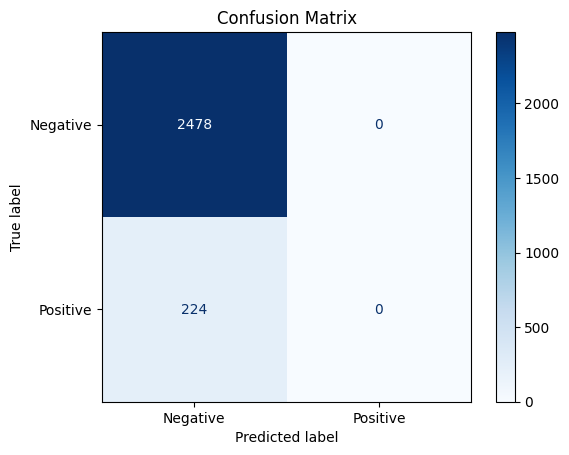

In [50]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/1p_lstm_baseline_cm')

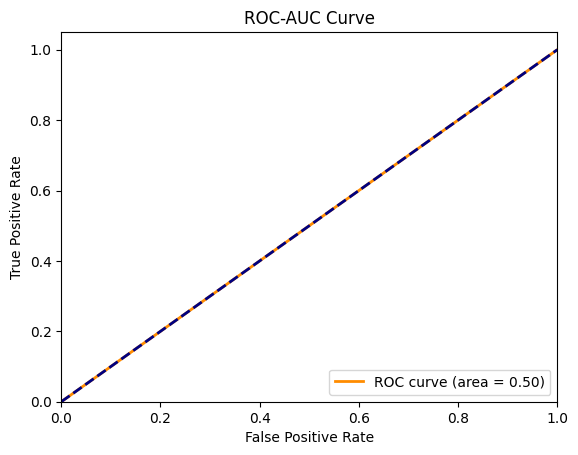

In [51]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/1p_lstm_baseline_roc_auc')

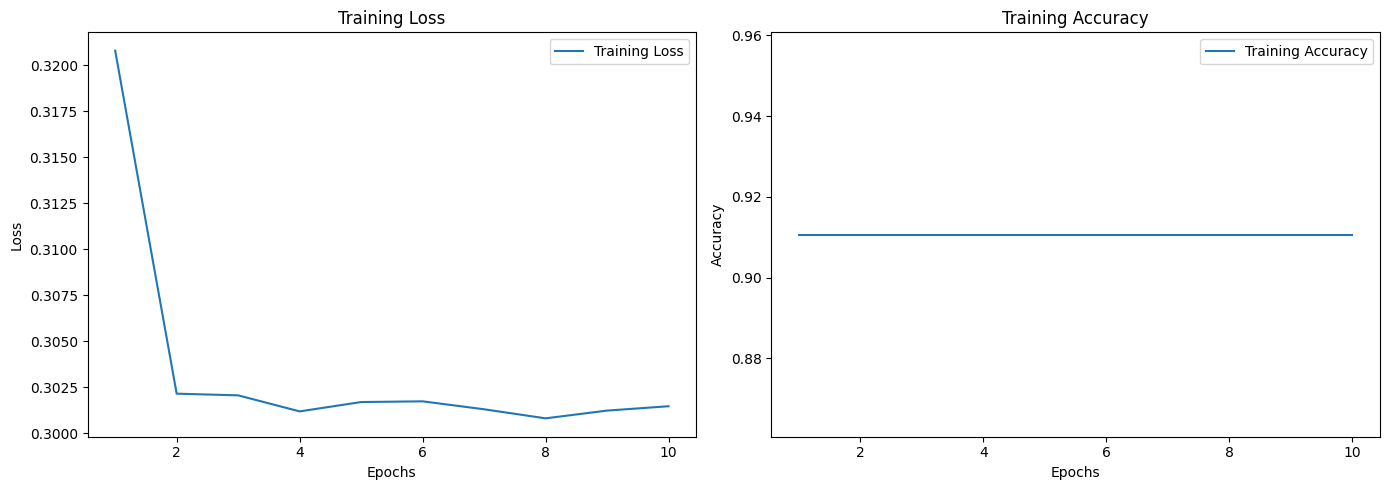

In [52]:
hf.plot_history(history)

### Transformer

In [163]:
# input_layer = Input(shape=(sequence_len), name='Input')


# x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)
# x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)


# for i in range(2):
#     attention = MultiHeadAttention(num_heads=4, key_dim=embedding_dim, name=f'Attention_{i}')(x, x) 
#     attention = Dropout(0.1, name=f'Dropout1_b{i}')(attention)

#     attention = tf.cast(attention, dtype=tf.float16)
#     x = tf.cast(x, dtype=tf.float16) 
    
#     x = LayerNormalization(epsilon=1e-6, name=f'LayerNorm1_{i}')(x + attention)
    
#     dense = Dense(embedding_dim, activation='relu', name=f'Dense1_b{i}')(x)
#     dense = Dense(embedding_dim, activation='relu', name=f'Dense2_{i}')(dense)
    
#     dense = Dropout(0.1, name=f'Dropout2_b{i}')(dense)
    
#     x = LayerNormalization(epsilon=1e-6, name=f'LayerNorm2_{i}')(x + dense)


# x = GlobalAveragePooling1D(name='GAPooling1D')(x)
# x = Dropout(0.1, name='Dropout')(x)

# outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [148]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')


x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)
x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)


attention = MultiHeadAttention(num_heads=10, key_dim=embedding_dim, name='Attention1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)
x = Dropout(0.1, name='Dropout')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [149]:
transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_1.compile(optimizer=tf.keras.optimizers.AdamW(), loss="binary_focal_crossentropy", metrics=['accuracy'])

In [150]:
transformer_1.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 997)]                0         []                            
                                                                                                  
 Embeddings (Embedding)      (None, 997, 400)             9200      ['Input[0][0]']               
                                                                                                  
 positional_encoding_9 (Pos  (None, 997, 400)             0         ['Embeddings[0][0]']          
 itionalEncoding)                                                                                 
                                                                                                  
 Attention1 (MultiHeadAtten  (None, 997, 400)             6412400   ['positional_encoding_9

In [158]:
history = transformer_1.fit(sequences_1p_train, labels_1p_train, epochs=15, batch_size=32)

Epoch 1/15
338/338 [==============================] - 98s 288ms/step - loss: 0.0765 - accuracy: 0.9168
Epoch 2/15
338/338 [==============================] - 97s 288ms/step - loss: 0.0761 - accuracy: 0.9158
Epoch 3/15
338/338 [==============================] - 97s 288ms/step - loss: 0.0759 - accuracy: 0.9172
Epoch 4/15
338/338 [==============================] - 98s 289ms/step - loss: 0.0757 - accuracy: 0.9182
Epoch 5/15
338/338 [==============================] - 98s 289ms/step - loss: 0.0753 - accuracy: 0.9187
Epoch 6/15
338/338 [==============================] - 97s 288ms/step - loss: 0.0756 - accuracy: 0.9160
Epoch 7/15
338/338 [==============================] - 97s 288ms/step - loss: 0.0753 - accuracy: 0.9174
Epoch 8/15
338/338 [==============================] - 97s 288ms/step - loss: 0.0751 - accuracy: 0.9178
Epoch 9/15
338/338 [==============================] - 97s 288ms/step - loss: 0.0757 - accuracy: 0.9150
Epoch 10/15
338/338 [==============================] - 98s 289ms/step - l

In [159]:
predictions = transformer_1.predict(sequences_1p_test)

85/85 [==============================] - 9s 106ms/step


In [160]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.9204293116210215
Loss:  0.4094


In [161]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.93      0.99      0.96      2478
    Positive       0.56      0.18      0.28       224

    accuracy                           0.92      2702
   macro avg       0.75      0.59      0.62      2702
weighted avg       0.90      0.92      0.90      2702



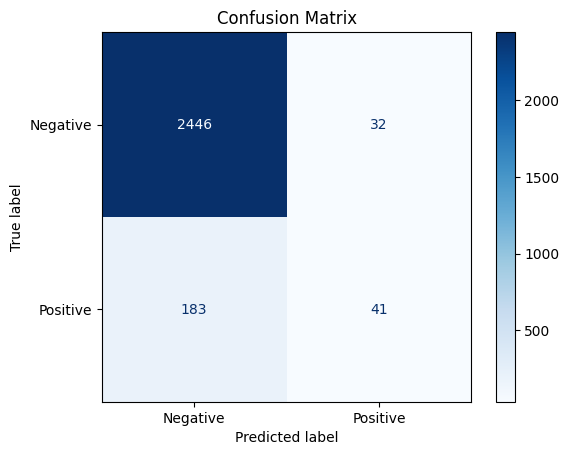

In [162]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/1p_transformer_1_cm')

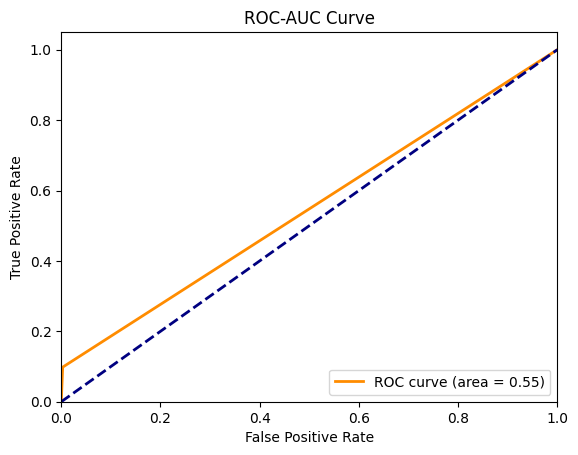

In [156]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/1p_transformer_1_roc_auc')

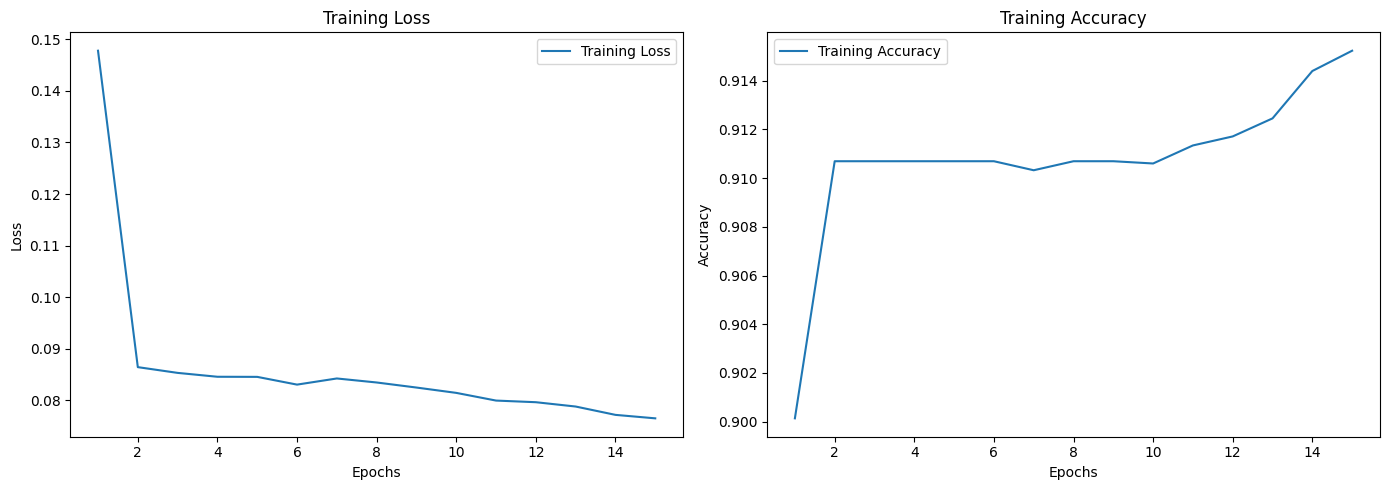

In [157]:
hf.plot_history(history)

### CNN Transformer

In [66]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')
input_layer = Reshape((sequence_len, 1))(input_layer)

# x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)

cnn = Conv1D(filters=embedding_dim, kernel_size=6, padding='same', activation='relu', name='Conv1D_1')(input_layer)

x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(cnn)


attention = MultiHeadAttention(num_heads=10, key_dim=embedding_dim, name='Attention_1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm_1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense_1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense_2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm_2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)
x = Dropout(0.1, name='Dropout')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [73]:
cnn_transformer_1 = Model(inputs=input_layer, outputs=outputs_layer)
cnn_transformer_1.compile(optimizer=tf.keras.optimizers.AdamW(),
                          loss="binary_focal_crossentropy",
                          metrics=[tf.keras.metrics.Precision(),
                                   tf.keras.metrics.Recall()])

In [74]:
cnn_transformer_1.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 997, 1)]             0         []                            
                                                                                                  
 Conv1D_1 (Conv1D)           (None, 997, 500)             3500      ['input_8[0][0]']             
                                                                                                  
 positional_encoding_8 (Pos  (None, 997, 500)             0         ['Conv1D_1[2][0]']            
 itionalEncoding)                                                                                 
                                                                                                  
 Attention_1 (MultiHeadAtte  (None, 997, 500)             1001550   ['positional_encoding_8[

In [75]:
history = cnn_transformer_1.fit(sequences_1p_train, labels_1p_train, epochs=30, batch_size=32)

Epoch 1/30
194/338 [================>.............] - ETA: 49s - loss: 0.0763 - precision_3: 0.7361 - recall_3: 0.0969


KeyboardInterrupt



In [ ]:
predictions = cnn_transformer_1.predict(sequences_1p_test)

In [71]:
predictions = hf.model_accuracy(labels_1p_test, predictions)

Accuracy:  0.9204293116210215
F1 Score:  0.18867924528301888
Loss:  0.374


In [72]:
hf.class_report(labels_1p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.93      0.99      0.96      2478
    Positive       0.61      0.11      0.19       224

    accuracy                           0.92      2702
   macro avg       0.77      0.55      0.57      2702
weighted avg       0.90      0.92      0.89      2702



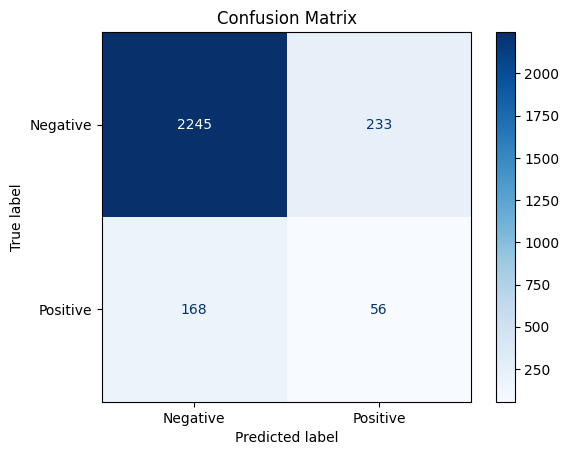

In [66]:
hf.conf_matrix(labels_1p_test, predictions, '1_pair/1p_cnn_transformer_1_cm')

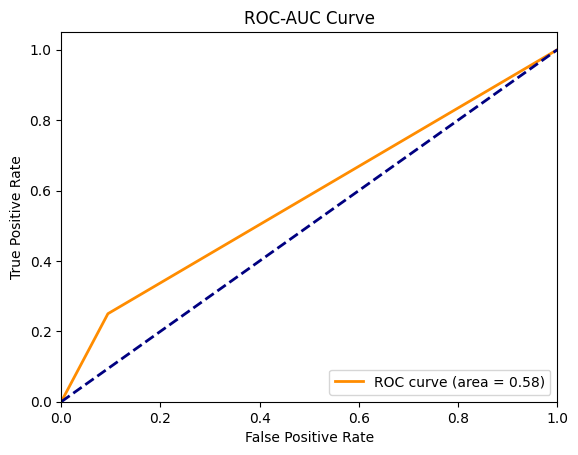

In [67]:
hf.roc_auc_curve(labels_1p_test, predictions, '1_pair/1p_cnn_transformer_1_roc_auc')

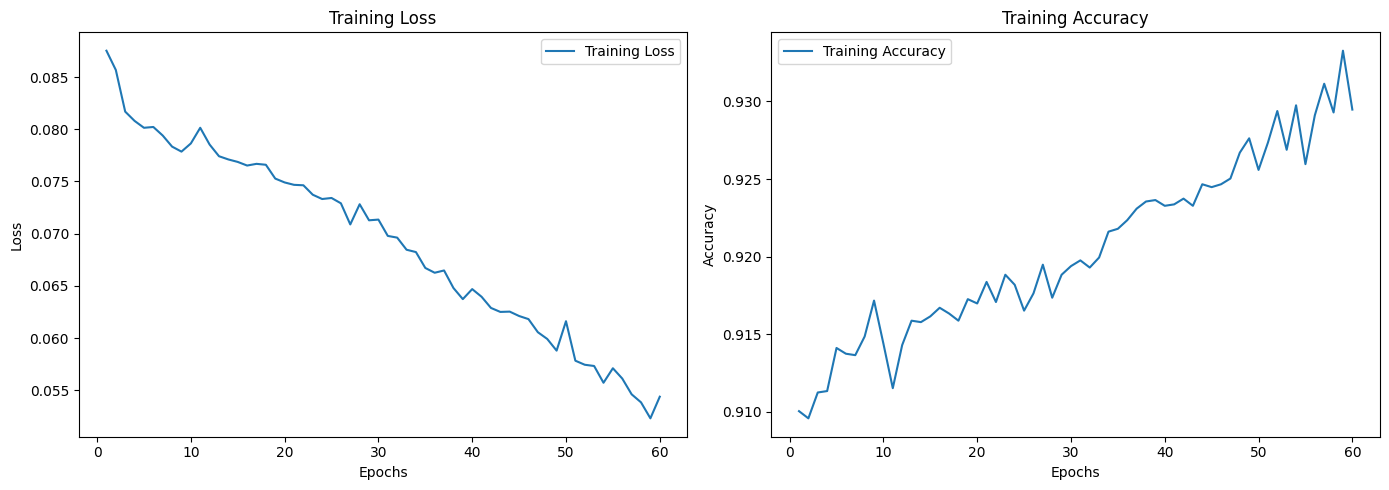

In [68]:
hf.plot_history(history)

## Modeling (2 Aminos Tokenization)

In [164]:
sequence_len = sequences_2p_train.shape[1]
voc_size = len(tokenizer2.word_index)
embedding_dim = 500

voc_size

466

### LSTM

In [61]:
inputs = Input(shape=(sequence_len), name='Input')
embeddings = Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=sequence_len, name='Embeddings')(inputs)

lstms1 = LSTM(20, name='LSTM_layer_1', return_sequences=True)(embeddings)
x = Dropout(0.1)(lstms1)
lstms2 = LSTM(20, name='LSTM_layer_2', return_sequences=True)(x)
x = Dropout(0.1)(lstms1)
lstms3 = LSTM(20, name='LSTM_layer_3')(x)

dense1 = Dense(10, activation='relu', name='Dense_1')(lstms3)
dense2 = Dense(5, activation='relu', name='Dense_2')(dense1)

outputs = Dense(1, activation=tf.keras.activations.hard_sigmoid, name='Output')(dense2)

In [62]:
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 1014)]            0         
                                                                 
 Embeddings (Embedding)      (None, 1014, 400)         186400    
                                                                 
 LSTM_layer_1 (LSTM)         (None, 1014, 20)          33680     
                                                                 
 dropout_3 (Dropout)         (None, 1014, 20)          0         
                                                                 
 LSTM_layer_3 (LSTM)         (None, 20)                3280      
                                                                 
 Dense_1 (Dense)             (None, 10)                210       
                                                                 
 Dense_2 (Dense)             (None, 5)                 55  

In [63]:
model_1.compile(optimizer=tf.keras.optimizers.Adamax(), loss=tf.keras.losses.binary_focal_crossentropy, metrics=['accuracy'])

In [64]:
history = model_1.fit(sequences_2p_train, labels_2p_train, epochs=2, batch_size=25)

Epoch 1/2
454/454 [==============================] - 47s 100ms/step - loss: 0.0835 - accuracy: 0.9098
Epoch 2/2
454/454 [==============================] - 46s 102ms/step - loss: 0.0828 - accuracy: 0.9098


In [65]:
predictions = model_1.predict(sequences_2p_test)

89/89 [==============================] - 5s 50ms/step


In [66]:
predictions = hf.model_accuracy(labels_2p_test, predictions)

Accuracy:  0.9110483586304271
Loss:  0.4338


In [67]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95      2581
    Positive       0.00      0.00      0.00       252

    accuracy                           0.91      2833
   macro avg       0.46      0.50      0.48      2833
weighted avg       0.83      0.91      0.87      2833



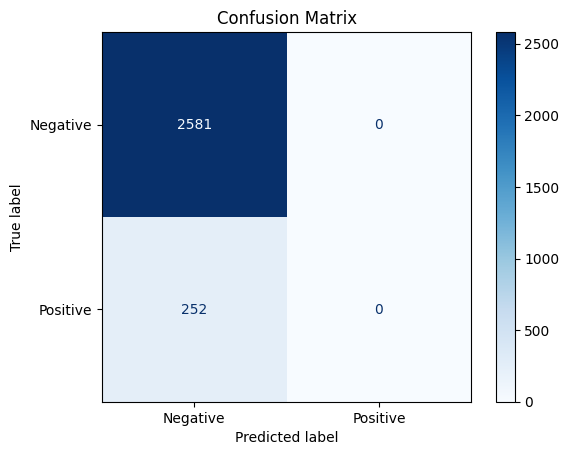

In [68]:
hf.conf_matrix(labels_2p_test, predictions, '2_pair/2p_lstm_baseline_cm')

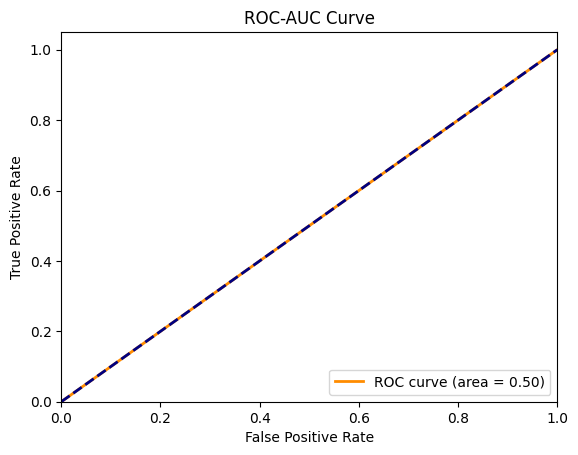

In [69]:
hf.roc_auc_curve(labels_2p_test, predictions, '2_pair/2p_lstm_baseline_roc_auc')

### Transformer

In [105]:
# input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')

# x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)

# x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)

# for i in range(4):
#     x = hf.transformer_block(x, 3, embedding_dim, i)

# x = GlobalAveragePooling1D(name='GAPooling1D')(x)
# x = Dropout(0.1, name='Dropout2')(x)

# outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [167]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')


x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)
x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)


attention = MultiHeadAttention(num_heads=10, key_dim=embedding_dim, name='Attention1')(x, x)
attention = Dropout(0.1, name='Dropout1')(attention)

attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm2')(x + dense)
x = GlobalAveragePooling1D(name='GAPooling1D')(x)
x = Dropout(0.1, name='Dropout2')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [168]:
transformer_2 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_2.compile(optimizer=tf.keras.optimizers.AdamW(), loss=tf.keras.losses.binary_focal_crossentropy, metrics=["accuracy"])

In [169]:
transformer_2.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 499)]                0         []                            
                                                                                                  
 Embeddings (Embedding)      (None, 499, 500)             233000    ['Input[0][0]']               
                                                                                                  
 positional_encoding_11 (Po  (None, 499, 500)             0         ['Embeddings[0][0]']          
 sitionalEncoding)                                                                                
                                                                                                  
 Attention1 (MultiHeadAtten  (None, 499, 500)             1001550   ['positional_encoding_1

In [177]:
history = transformer_2.fit(sequences_2p_train, labels_2p_train, epochs=30, batch_size=32)

Epoch 1/30
338/338 [==============================] - 56s 163ms/step - loss: 0.0834 - accuracy: 0.9090
Epoch 2/30
338/338 [==============================] - 53s 158ms/step - loss: 0.0818 - accuracy: 0.9107
Epoch 3/30
338/338 [==============================] - 54s 161ms/step - loss: 0.0814 - accuracy: 0.9107
Epoch 4/30
338/338 [==============================] - 55s 163ms/step - loss: 0.0815 - accuracy: 0.9107
Epoch 5/30
338/338 [==============================] - 54s 159ms/step - loss: 0.0809 - accuracy: 0.9107
Epoch 6/30
338/338 [==============================] - 55s 162ms/step - loss: 0.0804 - accuracy: 0.9107
Epoch 7/30
338/338 [==============================] - 55s 163ms/step - loss: 0.0799 - accuracy: 0.9107
Epoch 8/30
338/338 [==============================] - 55s 163ms/step - loss: 0.0797 - accuracy: 0.9107
Epoch 9/30
338/338 [==============================] - 52s 155ms/step - loss: 0.0800 - accuracy: 0.9106
Epoch 10/30
338/338 [==============================] - 50s 149ms/step - l

In [178]:
predictions = transformer_2.predict(sequences_2p_test)

85/85 [==============================] - 5s 53ms/step


In [179]:
predictions = hf.model_accuracy(labels_2p_test, predictions)

Accuracy:  0.917098445595855
Loss:  0.3782


In [180]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.92      1.00      0.96      2478
    Positive       0.00      0.00      0.00       224

    accuracy                           0.92      2702
   macro avg       0.46      0.50      0.48      2702
weighted avg       0.84      0.92      0.88      2702



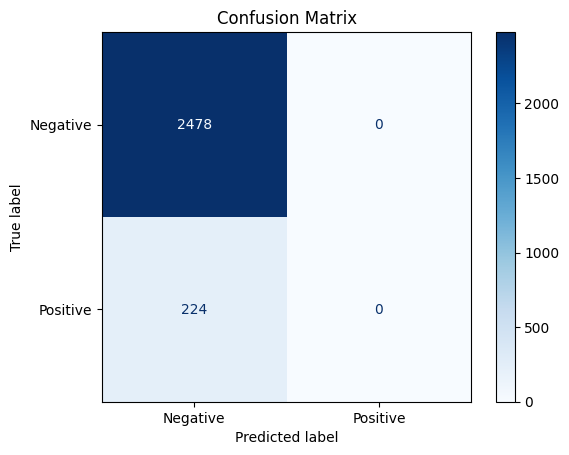

In [181]:
hf.conf_matrix(labels_2p_test, predictions, '2_pair/2p_transformer_1_cm')

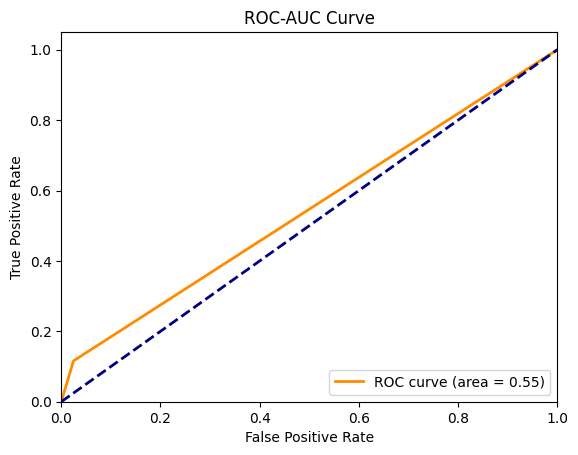

In [175]:
hf.roc_auc_curve(labels_2p_test, predictions, '2_pair/2p_transformer_1_roc_auc')

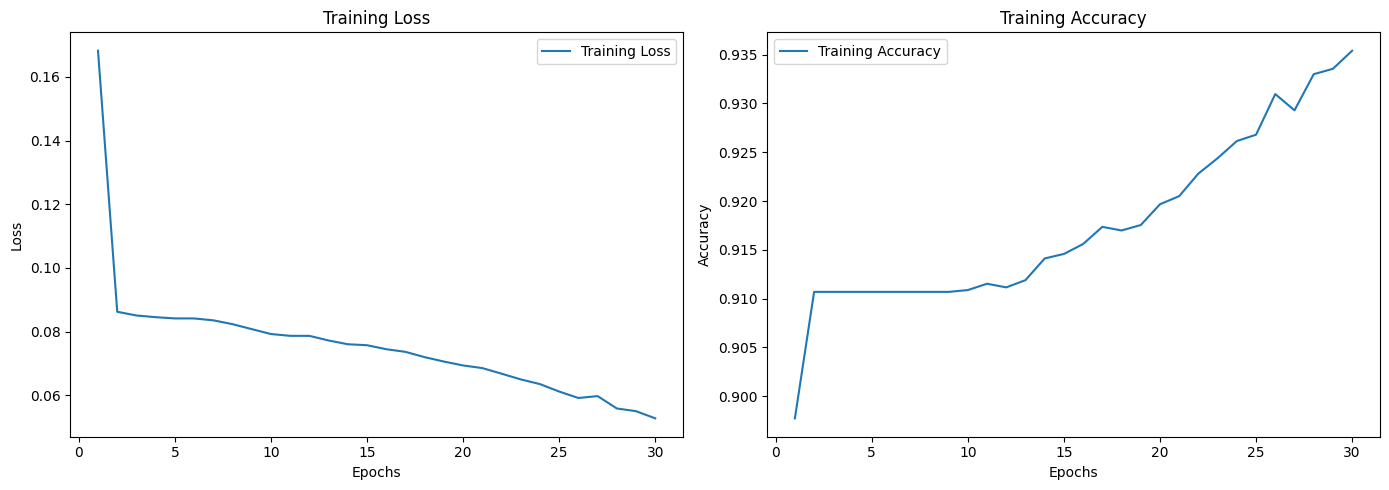

In [176]:
hf.plot_history(history)

## Modeling (3 Aminos Tokenization)

In [159]:
sequence_len = sequences_3p_train.shape[1]
voc_size = len(tokenizer3.word_index)
embedding_dim = 400

voc_size

8476

### LSTM

In [81]:
inputs = Input(shape=(sequence_len), name='Input')
embeddings = Embedding(input_dim=voc_size, output_dim=embedding_dim, input_length=sequence_len, name='Embeddings')(inputs)

lstms1 = LSTM(20, name='LSTM_layer_1', return_sequences=True)(embeddings)
x = Dropout(0.1)(lstms1)
lstms2 = LSTM(20, name='LSTM_layer_2', return_sequences=True)(x)
x = Dropout(0.1)(lstms1)
lstms3 = LSTM(20, name='LSTM_layer_3')(x)

dense1 = Dense(10, activation='relu', name='Dense_1')(lstms3)
dense2 = Dense(5, activation='relu', name='Dense_2')(dense1)

outputs = Dense(1, activation=tf.keras.activations.hard_sigmoid, name='Output')(dense2)

In [82]:
model_1 = Model(inputs=inputs, outputs=outputs)
model_1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 676)]             0         
                                                                 
 Embeddings (Embedding)      (None, 676, 400)          3390800   
                                                                 
 LSTM_layer_1 (LSTM)         (None, 676, 20)           33680     
                                                                 
 dropout_5 (Dropout)         (None, 676, 20)           0         
                                                                 
 LSTM_layer_3 (LSTM)         (None, 20)                3280      
                                                                 
 Dense_1 (Dense)             (None, 10)                210       
                                                                 
 Dense_2 (Dense)             (None, 5)                 55  

In [90]:
model_1.compile(optimizer=tf.keras.optimizers.Adamax(), loss=tf.keras.losses.binary_focal_crossentropy, metrics=['accuracy'])

In [91]:
history = model_1.fit(sequences_3p_train, labels_3p_train, epochs=8, batch_size=25)

Epoch 1/8
454/454 [==============================] - 66s 143ms/step - loss: 0.0840 - accuracy: 0.9098
Epoch 2/8
454/454 [==============================] - 51s 111ms/step - loss: 0.0828 - accuracy: 0.9098
Epoch 3/8
454/454 [==============================] - 44s 96ms/step - loss: 0.0826 - accuracy: 0.9098
Epoch 4/8
454/454 [==============================] - 41s 91ms/step - loss: 0.0827 - accuracy: 0.9098
Epoch 5/8
454/454 [==============================] - 36s 80ms/step - loss: 0.0827 - accuracy: 0.9098
Epoch 6/8
454/454 [==============================] - 39s 85ms/step - loss: 0.0825 - accuracy: 0.9098
Epoch 7/8
454/454 [==============================] - 36s 80ms/step - loss: 0.0825 - accuracy: 0.9098
Epoch 8/8
454/454 [==============================] - 34s 75ms/step - loss: 0.0827 - accuracy: 0.9098


In [93]:
predictions = model_1.predict(sequences_3p_test)

89/89 [==============================] - 3s 29ms/step


In [94]:
predictions = hf.model_accuracy(labels_3p_test, predictions)

Accuracy:  0.9110483586304271
Loss:  0.4358


In [95]:
hf.class_report(labels_2p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.91      1.00      0.95      2581
    Positive       0.00      0.00      0.00       252

    accuracy                           0.91      2833
   macro avg       0.46      0.50      0.48      2833
weighted avg       0.83      0.91      0.87      2833



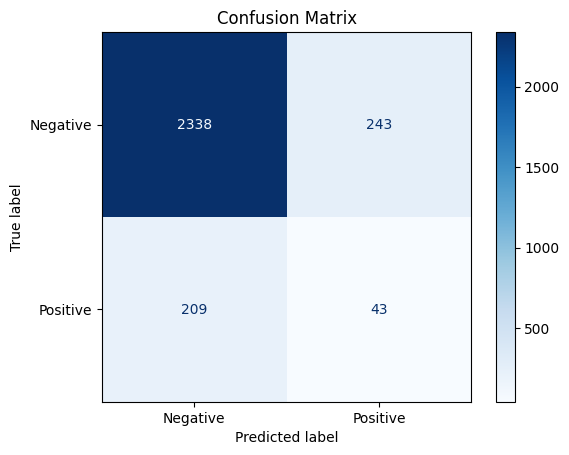

In [58]:
hf.conf_matrix(labels_3p_test, predictions, '3_pair/3p_lstm_baseline_cm')

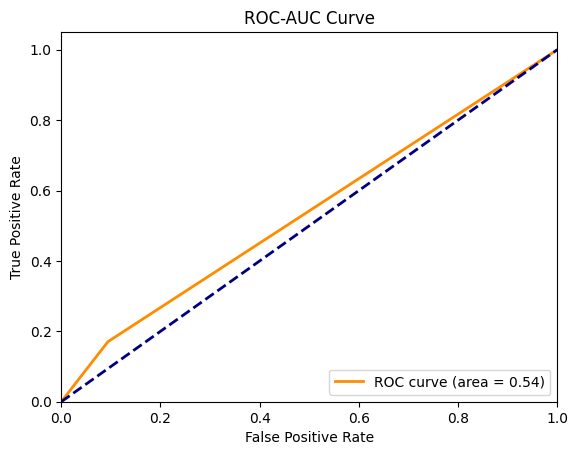

In [59]:
hf.roc_auc_curve(labels_3p_test, predictions, '3_pair/3p_lstm_baseline_roc_auc')

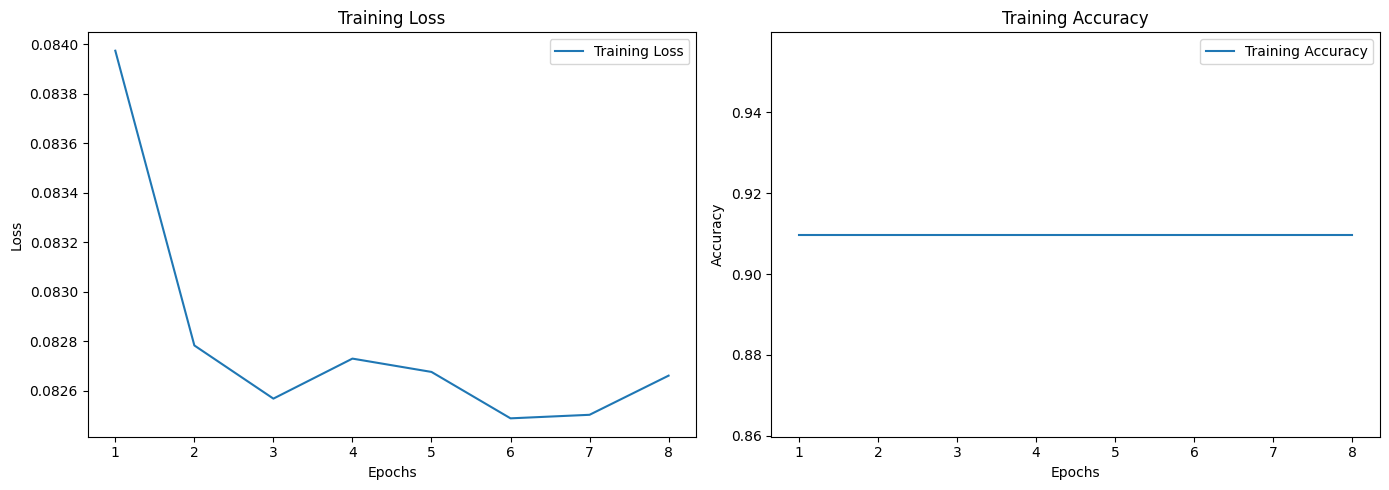

In [98]:
hf.plot_history(history)

### Transformer

In [181]:
input_layer = Input(shape=(sequence_len), dtype=tf.float32, name='Input')

x = Embedding(input_dim=voc_size, output_dim=embedding_dim, name='Embeddings')(input_layer)
x = PositionalEncoding(position=sequence_len, d_model=embedding_dim)(x)

attention = MultiHeadAttention(num_heads=2, key_dim=embedding_dim, name='Attention1')(x, x)
attention = tf.cast(attention, dtype=tf.float32)  

x = LayerNormalization(epsilon=1e-6, name='LayerNorm1')(x + attention)

dense = Dense(embedding_dim, activation='relu', name='Dense1')(x)
dense = Dense(embedding_dim, activation='relu', name='Dense2')(dense)

x = LayerNormalization(epsilon=1e-6, name='LayerNorm2')(x + dense)

x = GlobalAveragePooling1D(name='GAPooling1D')(x)

outputs_layer = Dense(1, activation="sigmoid", name='Output')(x)

In [182]:
transformer_3 = Model(inputs=input_layer, outputs=outputs_layer)
transformer_3.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.binary_crossentropy, metrics=["accuracy"])

In [183]:
transformer_3.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 333)]                0         []                            
                                                                                                  
 Embeddings (Embedding)      (None, 333, 400)             3390400   ['Input[0][0]']               
                                                                                                  
 positional_encoding_18 (Po  (None, 333, 400)             0         ['Embeddings[0][0]']          
 sitionalEncoding)                                                                                
                                                                                                  
 Attention1 (MultiHeadAtten  (None, 333, 400)             1282800   ['positional_encoding_1

In [184]:
history = transformer_3.fit(sequences_3p_train, labels_3p_train, epochs=30, batch_size=32)

Epoch 1/30
338/338 [==============================] - 25s 69ms/step - loss: 0.3122 - accuracy: 0.9107
Epoch 2/30
338/338 [==============================] - 18s 53ms/step - loss: 0.3036 - accuracy: 0.9107
Epoch 3/30
338/338 [==============================] - 15s 46ms/step - loss: 0.3049 - accuracy: 0.9107
Epoch 4/30
338/338 [==============================] - 15s 45ms/step - loss: 0.3036 - accuracy: 0.9107
Epoch 5/30
338/338 [==============================] - 14s 41ms/step - loss: 0.3032 - accuracy: 0.9107
Epoch 6/30
338/338 [==============================] - 13s 39ms/step - loss: 0.3031 - accuracy: 0.9107
Epoch 7/30
338/338 [==============================] - 13s 37ms/step - loss: 0.3028 - accuracy: 0.9107
Epoch 8/30
338/338 [==============================] - 12s 37ms/step - loss: 0.3084 - accuracy: 0.9107
Epoch 9/30
338/338 [==============================] - 13s 37ms/step - loss: 0.3072 - accuracy: 0.9107
Epoch 10/30
338/338 [==============================] - 12s 37ms/step - loss: 0.304

In [187]:
predictions = transformer_3.predict(sequences_3p_test)

85/85 [==============================] - 1s 11ms/step


In [188]:
predictions = hf.model_accuracy(labels_3p_test, predictions)

Accuracy:  0.8612139156180607
Loss:  0.702


In [189]:
hf.class_report(labels_3p_test, predictions)

              precision    recall  f1-score   support

    Negative       0.93      0.92      0.92      2478
    Positive       0.17      0.18      0.18       224

    accuracy                           0.86      2702
   macro avg       0.55      0.55      0.55      2702
weighted avg       0.86      0.86      0.86      2702



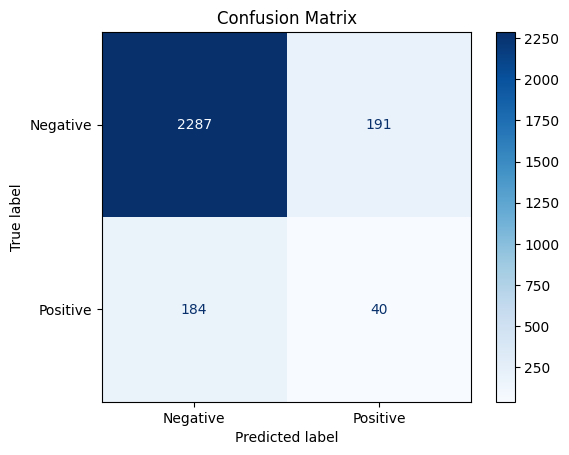

In [190]:
hf.conf_matrix(labels_3p_test, predictions, '3_pair/3p_transformer_1_cm')

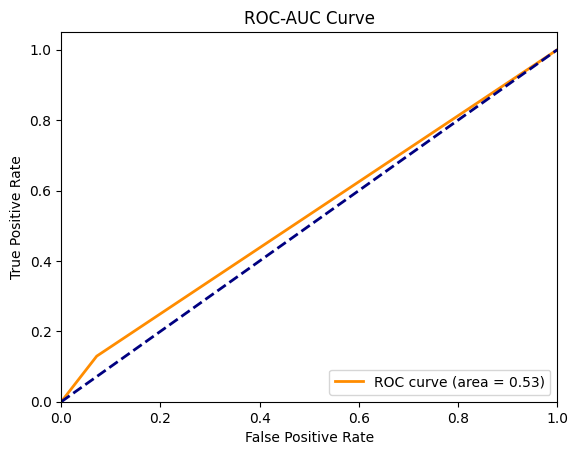

In [179]:
hf.roc_auc_curve(labels_3p_test, predictions, '3_pair/3p_transformer_1_roc_auc')

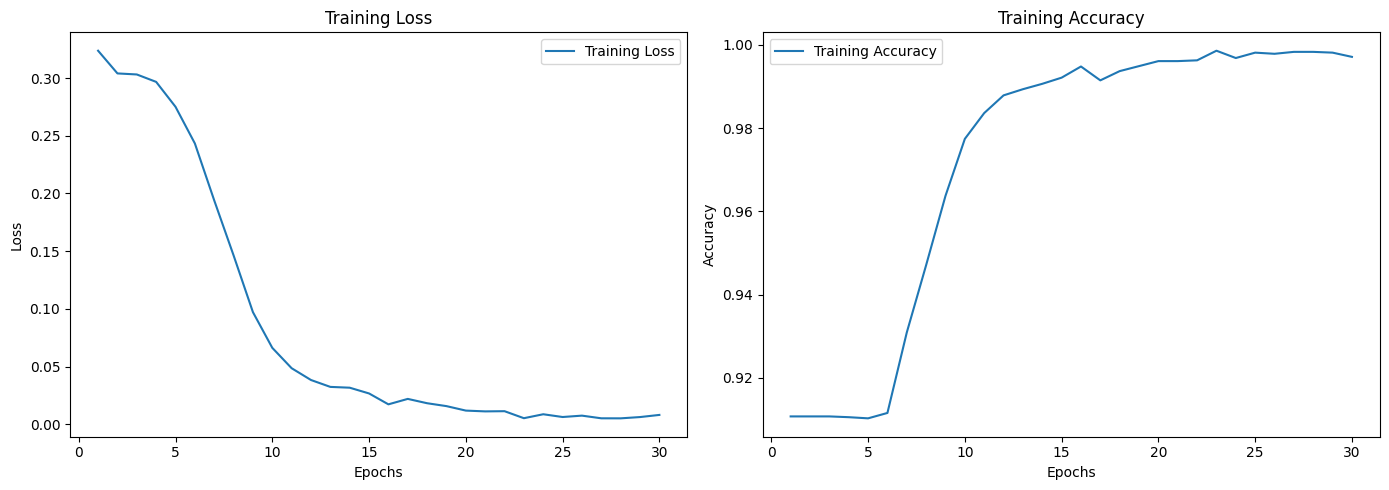

In [180]:
hf.plot_history(history)